In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.plotly as py
import plotly.graph_objs as go
import dask.dataframe as dd
from sklearn.cluster import KMeans
from scipy import linalg
from sklearn.mixture import GaussianMixture
from scipy import cluster
from sklearn.metrics import silhouette_score, calinski_harabaz_score
from scipy.spatial.distance import cdist, pdist
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler,Normalizer
from sklearn.decomposition import PCA
import sys



# 1. Data proprocessing

In [2]:
# Load the dataset
columns = [
       'guiAccess.homeid', 
       'guiAccess.userid', 
       'guiAccess.timestamp',
       'guiAccess.url',
       'guiAccess.browseTips.feedbackId',
       'guiAccess.browseTips.feedbackType', 
       'guiAccess.browseTips.index',
       'guiAccess.browseTips.questionSetId',
       'guiAccess.surveyPresentation.feedback.feedbackId',
       'guiAccess.surveyPresentation.feedback.feedbackType',
       'guiAccess.surveyPresentation.feedback.index',
       'guiAccess.surveyPresentation.feedback.questionSetId',
       'guiAccess.surveyPresentation.source',
       'guiAccess.tipPresentation.feedback.feedbackId',
       'guiAccess.tipPresentation.feedback.feedbackType',
       'guiAccess.tipPresentation.source',
       'guiAccess.gaugeToggle.displayCost',
       'guiAccess.gaugeToggle.sensor',
       'guiAccess.historicalChartDescription.compareEnd1',
       'guiAccess.historicalChartDescription.compareEnd2',
       'guiAccess.historicalChartDescription.compareStart1',
       'guiAccess.historicalChartDescription.compareStart2',
       'guiAccess.historicalChartDescription.dateIndex',
       'guiAccess.historicalChartDescription.displayCost',
       'guiAccess.historicalChartDescription.roomId',
       'guiAccess.historicalChartDescription.secondSensorType',
       'guiAccess.historicalChartDescription.sensorType',
       'guiAccess.historicalChartDescription.sensors', 
]

input_filename = '../clickdata_new.csv'
clickdata_dataset = pd.read_csv(input_filename, encoding='utf-8', usecols=columns, engine='python')

In [3]:
# Have a feeling about the data
clickdata_dataset.head()

,guiAccess.browseTips.feedbackId,guiAccess.browseTips.feedbackType,guiAccess.browseTips.index,guiAccess.browseTips.questionSetId,guiAccess.gaugeToggle.displayCost,guiAccess.gaugeToggle.sensor,guiAccess.historicalChartDescription.compareEnd1,guiAccess.historicalChartDescription.compareEnd2,guiAccess.historicalChartDescription.compareStart1,guiAccess.historicalChartDescription.compareStart2,...,guiAccess.surveyPresentation.feedback.feedbackType,guiAccess.surveyPresentation.feedback.index,guiAccess.surveyPresentation.feedback.questionSetId,guiAccess.surveyPresentation.source,guiAccess.timestamp,guiAccess.tipPresentation.feedback.feedbackId,guiAccess.tipPresentation.feedback.feedbackType,guiAccess.tipPresentation.source,guiAccess.url,guiAccess.userid
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2016-08-10 11:57:27,NaN,NaN,NaN,/welcome,Aisling
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2016-08-10 11:57:28,NaN,NaN,NaN,/readWeatherForecast/,Aisling
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2016-08-10 11:57:28,NaN,NaN,NaN,/readSensors/,Aisling
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2016-08-10 11:57:33,NaN,NaN,NaN,/readSensors/,Aisling
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2016-08-10 11:57:38,NaN,NaN,NaN,/readSensors/,Aisling


In [4]:
# Sort the data by userid first and then timestamp
clickdata_dataset['guiAccess.timestamp'] = pd.to_datetime(clickdata_dataset['guiAccess.timestamp'], errors='coerce')
clickdata_dataset = clickdata_dataset.sort_values(by=['guiAccess.userid','guiAccess.timestamp'])
clickdata_dataset = clickdata_dataset.reset_index(drop=True)
clickdata_dataset.head()

,guiAccess.browseTips.feedbackId,guiAccess.browseTips.feedbackType,guiAccess.browseTips.index,guiAccess.browseTips.questionSetId,guiAccess.gaugeToggle.displayCost,guiAccess.gaugeToggle.sensor,guiAccess.historicalChartDescription.compareEnd1,guiAccess.historicalChartDescription.compareEnd2,guiAccess.historicalChartDescription.compareStart1,guiAccess.historicalChartDescription.compareStart2,...,guiAccess.surveyPresentation.feedback.feedbackType,guiAccess.surveyPresentation.feedback.index,guiAccess.surveyPresentation.feedback.questionSetId,guiAccess.surveyPresentation.source,guiAccess.timestamp,guiAccess.tipPresentation.feedback.feedbackId,guiAccess.tipPresentation.feedback.feedbackType,guiAccess.tipPresentation.source,guiAccess.url,guiAccess.userid
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2017-04-25 06:26:10,NaN,NaN,NaN,/welcome,3bMcF56P1wWvJ82
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2017-04-25 06:26:12,NaN,NaN,NaN,/logGuiAccess,3bMcF56P1wWvJ82
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2017-04-25 06:26:12,NaN,NaN,NaN,/readWeatherForecast/,3bMcF56P1wWvJ82
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2017-04-25 06:26:12,NaN,NaN,NaN,/readSensors/,3bMcF56P1wWvJ82
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2017-04-25 06:26:17,NaN,NaN,NaN,/readSensors/,3bMcF56P1wWvJ82


In [5]:
# Insert a new column that represents sessions
clickdata_dataset.insert(0, 'session.id', value = 0) # column 0
# Insert a new column that records the time duration during a session
clickdata_dataset.insert(1, 'session.duration', value = 0) # column 1
# insert a new column that represents whether the historicalChartDescription field in this row is valid or not
clickdata_dataset.insert(2, 'histChartDesc.isValid', value = False) # column 2
# insert a new column that records the time the user spend in historicalChartDescription page (seconds)
clickdata_dataset.insert(3, 'histChartDesc.duration', value = 0) # column 3
# insert a new column that records the number of tips the user viewed
clickdata_dataset.insert(4, 'tips.count', value = 0) # column 4
# insert a new column that records the time the user spend in tips page (seconds)
clickdata_dataset.insert(5, 'tips.duration', value = 0) # column 5
# insert a new column that records the time the user spend in welcome page (seconds)
clickdata_dataset.insert(6, 'welcome.duration', value = 0) # column 5

In [6]:
clickdata_dataset.head()

,session.id,session.duration,histChartDesc.isValid,histChartDesc.duration,tips.count,tips.duration,welcome.duration,guiAccess.browseTips.feedbackId,guiAccess.browseTips.feedbackType,guiAccess.browseTips.index,...,guiAccess.surveyPresentation.feedback.feedbackType,guiAccess.surveyPresentation.feedback.index,guiAccess.surveyPresentation.feedback.questionSetId,guiAccess.surveyPresentation.source,guiAccess.timestamp,guiAccess.tipPresentation.feedback.feedbackId,guiAccess.tipPresentation.feedback.feedbackType,guiAccess.tipPresentation.source,guiAccess.url,guiAccess.userid
0,0,0,False,0,0,0,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2017-04-25 06:26:10,NaN,NaN,NaN,/welcome,3bMcF56P1wWvJ82
1,0,0,False,0,0,0,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2017-04-25 06:26:12,NaN,NaN,NaN,/logGuiAccess,3bMcF56P1wWvJ82
2,0,0,False,0,0,0,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2017-04-25 06:26:12,NaN,NaN,NaN,/readWeatherForecast/,3bMcF56P1wWvJ82
3,0,0,False,0,0,0,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2017-04-25 06:26:12,NaN,NaN,NaN,/readSensors/,3bMcF56P1wWvJ82
4,0,0,False,0,0,0,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2017-04-25 06:26:17,NaN,NaN,NaN,/readSensors/,3bMcF56P1wWvJ82


## 1.1 HistoricalChartDescription data

In [7]:
# Check the sessions that have valid historicalChartDescription data and calculate the time spent in this page
max_index = len(clickdata_dataset.index)
hist_index = clickdata_dataset[clickdata_dataset['guiAccess.historicalChartDescription.sensorType'].notnull()].index.tolist()
hist_index_1 = [x+1 if x+1 < max_index else x for x in hist_index ] 

for i,j in zip(hist_index, hist_index_1):
    time_start = clickdata_dataset.loc[i,'guiAccess.timestamp']
    time_end   = clickdata_dataset.loc[j,'guiAccess.timestamp']
    userid_start = clickdata_dataset.loc[i,'guiAccess.userid']
    userid_end = clickdata_dataset.loc[j,'guiAccess.userid']
    time_difference = time_end - time_start
    time_difference_in_minutes = time_difference / dt.timedelta(minutes=1)
    time_difference_in_seconds = time_difference / dt.timedelta(seconds=1)
    # if the time different is more then 10 minutes, system will log out automatically, so it is not in the same session
    # if the time different is more than 5 seconds, we assume that this record is valid since the user stays this page longer
    # the last condition is just double check
    if time_difference_in_minutes <= 10 and time_difference_in_seconds >= 5 and userid_start == userid_end:
        clickdata_dataset.loc[i, 'histChartDesc.isValid'] = True
        clickdata_dataset.loc[i, 'histChartDesc.duration'] = time_difference_in_seconds

In [8]:
clickdata_dataset[clickdata_dataset['histChartDesc.duration'] != 0].head()

,session.id,session.duration,histChartDesc.isValid,histChartDesc.duration,tips.count,tips.duration,welcome.duration,guiAccess.browseTips.feedbackId,guiAccess.browseTips.feedbackType,guiAccess.browseTips.index,...,guiAccess.surveyPresentation.feedback.feedbackType,guiAccess.surveyPresentation.feedback.index,guiAccess.surveyPresentation.feedback.questionSetId,guiAccess.surveyPresentation.source,guiAccess.timestamp,guiAccess.tipPresentation.feedback.feedbackId,guiAccess.tipPresentation.feedback.feedbackType,guiAccess.tipPresentation.source,guiAccess.url,guiAccess.userid
21,0,0,True,6.0,0,0,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2017-04-25 06:26:54,NaN,NaN,NaN,/userHistoryData,3bMcF56P1wWvJ82
123,0,0,True,5.0,0,0,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2017-05-07 09:18:01,NaN,NaN,NaN,/userHistoryData,9PkgfKWY6_aAs99
125,0,0,True,11.0,0,0,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2017-05-07 09:18:12,NaN,NaN,NaN,/userHistory/MONTH,9PkgfKWY6_aAs99
131,0,0,True,5.0,0,0,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2017-05-07 09:18:36,NaN,NaN,NaN,/userHistory/DAY_OF_WEEK,9PkgfKWY6_aAs99
132,0,0,True,14.0,0,0,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2017-05-07 09:18:41,NaN,NaN,NaN,/userHistory/HOUR,9PkgfKWY6_aAs99


## 1.2 Tips data

In [9]:
# count the number of tips the user viewed in each session
max_index = len(clickdata_dataset.index)
tips_index = clickdata_dataset[clickdata_dataset['guiAccess.browseTips.feedbackId'].notnull()].index.tolist()
tips_index_1 = tips_index[1:]
tips_index_1.insert(len(tips_index_1), tips_index[-1])

tips_count = 1

for (i,j) in zip(tips_index, tips_index_1):
    time_start = clickdata_dataset.loc[i,'guiAccess.timestamp']
    time_end   = clickdata_dataset.loc[j,'guiAccess.timestamp']
    userid_start = clickdata_dataset.loc[i,'guiAccess.userid']
    userid_end = clickdata_dataset.loc[j,'guiAccess.userid']
    time_difference = time_end - time_start
    time_difference_in_minutes = time_difference / dt.timedelta(minutes=1)

    # judge if it is within the same session
    if time_difference_in_minutes < 10 and time_difference_in_minutes > 0 and userid_start == userid_end:
        tips_count += 1
    else:
        clickdata_dataset.loc[i, 'tips.count'] = tips_count
        tips_count = 1

In [10]:
# calculate the time the user spent in the tips page within each session
tips_index = clickdata_dataset[clickdata_dataset['guiAccess.browseTips.feedbackId'].notnull()].index.tolist()
tips_index_1 = [x+1 if x+1 < max_index else x for x in tips_index ] 

for i,j in zip(tips_index, tips_index_1):
    while True:
        j += 1
        if (clickdata_dataset.loc[j,'guiAccess.url'] != '/readSensors/'):
            break
    time_start = clickdata_dataset.loc[i,'guiAccess.timestamp']
    time_end   = clickdata_dataset.loc[j,'guiAccess.timestamp']
    userid_start = clickdata_dataset.loc[i,'guiAccess.userid']
    userid_end = clickdata_dataset.loc[j,'guiAccess.userid']
    time_difference = time_end - time_start
    time_difference_in_minutes = time_difference / dt.timedelta(minutes=1)
    time_difference_in_seconds = time_difference / dt.timedelta(seconds=1)
    # if the time different is more then 10 minutes, system will log out automatically, so it is not in the same session
    # the last condition is just double check
    if time_difference_in_minutes <= 10 and userid_start == userid_end:
        clickdata_dataset.loc[i, 'tips.duration'] = time_difference_in_seconds

In [11]:
clickdata_dataset[clickdata_dataset['tips.duration'] != 0]

,session.id,session.duration,histChartDesc.isValid,histChartDesc.duration,tips.count,tips.duration,welcome.duration,guiAccess.browseTips.feedbackId,guiAccess.browseTips.feedbackType,guiAccess.browseTips.index,...,guiAccess.surveyPresentation.feedback.feedbackType,guiAccess.surveyPresentation.feedback.index,guiAccess.surveyPresentation.feedback.questionSetId,guiAccess.surveyPresentation.source,guiAccess.timestamp,guiAccess.tipPresentation.feedback.feedbackId,guiAccess.tipPresentation.feedback.feedbackType,guiAccess.tipPresentation.source,guiAccess.url,guiAccess.userid
35609,0,0,False,0.0,1,20.0,0,17_TipSurvey,question,1.0,...,NaN,NaN,NaN,NaN,2016-12-29 14:17:06,NaN,NaN,NaN,/logGuiAccess,Alastair
37502,0,0,False,0.0,1,19.0,0,38_TipSurvey,question,1.0,...,NaN,NaN,NaN,NaN,2017-03-04 19:55:22,NaN,NaN,NaN,/logGuiAccess,Alastair
49811,0,0,False,0.0,1,45.0,0,42_TipSurvey,question,1.0,...,NaN,NaN,NaN,NaN,2017-05-08 22:00:30,NaN,NaN,NaN,/logGuiAccess,Alastair
72221,0,0,False,0.0,1,22.0,0,27_TipSurvey,question,1.0,...,NaN,NaN,NaN,NaN,2017-03-10 18:49:40,NaN,NaN,NaN,/logGuiAccess,Catherineduns
109751,0,0,False,0.0,1,41.0,0,62_TipSurvey,question,1.0,...,NaN,NaN,NaN,NaN,2017-05-04 14:05:22,NaN,NaN,NaN,/logGuiAccess,DrewJMurphy
109947,0,0,False,0.0,1,44.0,0,62_TipSurvey,question,1.0,...,NaN,NaN,NaN,NaN,2017-05-05 15:34:14,NaN,NaN,NaN,/logGuiAccess,DrewJMurphy
114914,0,0,False,0.0,1,17.0,0,77_TipSurvey,question,1.0,...,NaN,NaN,NaN,NaN,2017-04-25 18:23:24,NaN,NaN,NaN,/logGuiAccess,Emmahogg
127842,0,0,False,0.0,0,8.0,0,18_TipSurvey,question,1.0,...,NaN,NaN,NaN,NaN,2017-05-26 15:50:24,NaN,NaN,NaN,/logGuiAccess,Emmahogg
127866,0,0,False,0.0,2,49.0,0,18_TipSurvey,question,1.0,...,NaN,NaN,NaN,NaN,2017-05-26 15:51:43,NaN,NaN,NaN,/logGuiAccess,Emmahogg
183325,0,0,False,0.0,1,65.0,0,52,tip,NaN,...,NaN,NaN,NaN,NaN,2017-01-27 22:07:55,NaN,NaN,NaN,/logGuiAccess,IanWalker


In [12]:
# calculate the time the user spent in the tips page within each session
max_index = len(clickdata_dataset.index)
url_index = clickdata_dataset[clickdata_dataset['guiAccess.url'] == '/welcome'].index.tolist()

for i in url_index:
    j = i
    while True:
        j += 1
        if (clickdata_dataset.loc[j,'guiAccess.url'] != '/readSensors/') or (clickdata_dataset.loc[j,'guiAccess.url'] != '/readWeatherForecast/'):
            break
    time_start = clickdata_dataset.loc[i,'guiAccess.timestamp']
    time_end   = clickdata_dataset.loc[j,'guiAccess.timestamp']
    userid_start = clickdata_dataset.loc[i,'guiAccess.userid']
    userid_end = clickdata_dataset.loc[j,'guiAccess.userid']
    time_difference = time_end - time_start
    time_difference_in_minutes = time_difference / dt.timedelta(minutes=1)
    time_difference_in_seconds = time_difference / dt.timedelta(seconds=1)
    # if the time different is more then 10 minutes, system will log out automatically, so it is not in the same session
    # the last condition is just double check
    if time_difference_in_minutes <= 10 and userid_start == userid_end:
        clickdata_dataset.loc[i, 'welcome.duration'] = time_difference_in_seconds

## 1.3 Find the session

In [13]:
output_filename = 'clickdata_session.csv'
# Find a session: The time gap between the neighboring rows is more than 10 minutes
rows = len(clickdata_dataset.index)
session_id = 0
time_start = clickdata_dataset.loc[0,'guiAccess.timestamp']
time_session_begin = time_start

for i in range(1, rows):
    # set the session id for the last record
    clickdata_dataset.loc[i-1,'session.id'] = session_id
    
    time_end = clickdata_dataset.loc[i,'guiAccess.timestamp']
    
    time_difference = time_end - time_start
    time_difference_in_minutes = time_difference / dt.timedelta(minutes=1)
    
    if abs(time_difference_in_minutes) > 10: 
        time_session_end = clickdata_dataset.loc[i-1,'guiAccess.timestamp'] 
        # calculate the time duration of the last session
        time_duration = (time_session_end - time_session_begin) / dt.timedelta(minutes=1)
        
        # assign the time duration value to the field
        clickdata_dataset.loc[i-1,'session.duration'] = time_duration
        
        # set the session begin time for the new session
        time_session_begin = clickdata_dataset.loc[i,'guiAccess.timestamp'] 
        session_id += 1
    elif i == (rows-1): # consider it is the last session
        clickdata_dataset.loc[i,'session.id'] = session_id
        time_session_end = clickdata_dataset.loc[i,'guiAccess.timestamp'] 
        #calculate the time duration of the last session
        time_duration = (time_session_end - time_session_begin) / dt.timedelta(minutes=1)
        
        #assign the time duration value to the field
        clickdata_dataset.loc[i,'session.duration'] = time_duration
    time_start = time_end      

clickdata_dataset.to_csv(output_filename, header=True)

## 1.4 Refine the data

In [14]:
input_filename = './clickdata_session.csv'
clickdata_dataset = pd.read_csv(input_filename, encoding='utf-8', engine='python', index_col=0)

In [15]:
# initialize a new dataframe to store the refined data
columns = [
       'session.id',
       'session.duration',
       'guiAccess.homeid', 
       'guiAccess.userid', 
       'guiAccess.timestamp.start',
       'guiAccess.timestamp.end',
       'hist.electricity',
       'hist.gas',
       'hist.temperature',
       'hist.humidity',
       'hist.displayCost',
       'hist.notDisplayCost',
       'hist.comparingYear',
       'hist.comparingMonth',
       'hist.comparingWeek',
       'hist.comparingDay',
       'hist.singleRoom',
       'hist.multipleRoom',
       'hist.duration',
       'tips.count',
       'tips.duration',
       'gaugeToggle.displayCost',
       'gaugeToggle.notDisplayCost',
       'view.display',
       'others.duration',
       'welcome.duration'
        ]

dataset = pd.DataFrame(columns=columns)

In [16]:
max_session_id = len(clickdata_dataset['session.id'].unique())
for i in range(max_session_id):
    dataset.loc[i,'session.id'] = i
    dataset.loc[i,'session.duration'] = max(clickdata_dataset[clickdata_dataset['session.id'] == i]['session.duration'])
    dataset.loc[i,'guiAccess.homeid'] = max(clickdata_dataset[clickdata_dataset['session.id'] == i]['guiAccess.homeid'])
    dataset.loc[i,'guiAccess.userid'] = max(clickdata_dataset[clickdata_dataset['session.id'] == i]['guiAccess.userid'])
    dataset.loc[i,'guiAccess.timestamp.start'] = min(clickdata_dataset[clickdata_dataset['session.id'] == i]['guiAccess.timestamp'])
    dataset.loc[i,'guiAccess.timestamp.end'] = max(clickdata_dataset[clickdata_dataset['session.id'] == i]['guiAccess.timestamp'])
    dataset.loc[i,'hist.duration'] = max(clickdata_dataset[clickdata_dataset['session.id'] == i]['histChartDesc.duration'])
    dataset.loc[i,'tips.duration'] = max(clickdata_dataset[clickdata_dataset['session.id'] == i]['tips.duration'])
    dataset.loc[i,'tips.count'] = max(clickdata_dataset[clickdata_dataset['session.id'] == i]['tips.count'])

In [17]:
for i in range(max_session_id):
    # find the rows that have the same session id
    session_dataset = clickdata_dataset[clickdata_dataset['session.id'] == i]

    histChartDesc = session_dataset[session_dataset['histChartDesc.isValid'] == True]
    if histChartDesc.empty:
        pass
    else:
        # count the number of displaying cost/ not displaying cost 
        hist_displayCost = histChartDesc['guiAccess.historicalChartDescription.displayCost'].values
        True_count = 0
        False_count = 0

        for item in hist_displayCost:
            if item == True:
                True_count += 1
            if item == False:
                False_count += 1
        dataset.loc[i,'hist.displayCost'] = True_count
        dataset.loc[i,'hist.notDisplayCost'] = False_count
     
        # count the number of displaying different sensors
        sensors = histChartDesc['guiAccess.historicalChartDescription.sensorType'].values
        electricity_count = 0
        gas_count = 0
        temperature_count = 0
        humidity_count = 0
        for item in sensors:
            if item == 'electric':
                electricity_count += 1
            if item == 'gas':
                gas_count += 1   
            if item == 'temperature':
                temperature_count += 1
            if item == 'humidity':
                humidity_count += 1
        
        second_sensors = histChartDesc['guiAccess.historicalChartDescription.secondSensorType'].values
        for item in second_sensors:
            if item == 'electric':
                electricity_count += 1
            if item == 'gas':
                gas_count += 1   
            if item == 'temperature':
                temperature_count += 1
            if item == 'humidity':
                humidity_count += 1
        dataset.loc[i,'hist.electricity'] = electricity_count
        dataset.loc[i,'hist.gas'] = gas_count
        dataset.loc[i,'hist.temperature'] = temperature_count
        dataset.loc[i,'hist.humidity'] = humidity_count
        

        # count the number of displaying multiple rooms' information or single room's information
        rooms =  histChartDesc['guiAccess.historicalChartDescription.roomId'].values
        singleRoom_count = 0
        multipleRoom_count = 0
        for item in rooms:
            if item == -1.0:
                multipleRoom_count += 1
            else:
                singleRoom_count += 1
        dataset.loc[i,'hist.singleRoom'] = singleRoom_count
        dataset.loc[i,'hist.multipleRoom'] = multipleRoom_count
        
        # count the number of displaying year/month/week/day comparison
        histChartDesc['guiAccess.historicalChartDescription.compareStart1'] = pd.to_datetime(clickdata_dataset['guiAccess.historicalChartDescription.compareStart1'], errors='coerce')
        histChartDesc['guiAccess.historicalChartDescription.compareEnd1'] = pd.to_datetime(clickdata_dataset['guiAccess.historicalChartDescription.compareEnd1'], errors='coerce')
        histChartDesc = histChartDesc[histChartDesc['guiAccess.historicalChartDescription.compareEnd1'].notnull()]
        compare_start1 = histChartDesc['guiAccess.historicalChartDescription.compareStart1'].values
        compare_end1 = histChartDesc['guiAccess.historicalChartDescription.compareEnd1'].values
        max_len = len(histChartDesc['guiAccess.historicalChartDescription.compareStart1'])
        day_count = 0
        week_count = 0
        month_count = 0
        year_count = 0
        for time_start, time_end in zip(compare_start1,compare_end1):
            time_difference = time_end-time_start
            time_difference_day = time_difference.astype('timedelta64[D]') / np.timedelta64(1, 'D')
            if time_difference_day < 2:
                day_count += 1
            elif time_difference_day < 8 and time_difference_day > 3:
                week_count += 1
            elif time_difference_day < 32 and time_difference_day > 10:
                month_count += 1
            elif time_difference_day > 360:
                year_count += 1
        dataset.loc[i,'hist.comparingDay'] = day_count
        dataset.loc[i,'hist.comparingWeek'] = week_count
        dataset.loc[i,'hist.comparingMonth'] = month_count
        dataset.loc[i,'hist.comparingYear'] = year_count
        

/Users/mao/anaconda/envs/project/lib/python3.6/site-packages/ipykernel_launcher.py:67: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/mao/anaconda/envs/project/lib/python3.6/site-packages/ipykernel_launcher.py:68: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [18]:
for i in range(max_session_id):
    # find the rows that have the same session id
    session_dataset = clickdata_dataset[clickdata_dataset['session.id'] == i]

    gaugeToggle = session_dataset[session_dataset['guiAccess.gaugeToggle.displayCost'].notnull()]
    if gaugeToggle.empty:
        dataset.loc[i,'gaugeToggle.displayCost'] = 0
        dataset.loc[i,'gaugeToggle.notDisplayCost'] = 0
    else:
        # count the number of displaying cost/ not displaying cost 
        gaugeToggle_displayCost = gaugeToggle['guiAccess.gaugeToggle.displayCost'].values
        True_count = 0
        False_count = 0

        for item in gaugeToggle_displayCost:
            if item == True:
                True_count += 1
            if item == False:
                False_count += 1
        dataset.loc[i,'gaugeToggle.displayCost'] = True_count
        dataset.loc[i,'gaugeToggle.notDisplayCost'] = False_count

In [19]:
for i in range(max_session_id):
    # find the rows that have the same session id
    session_dataset = clickdata_dataset[clickdata_dataset['session.id'] == i]

    url_dataset = session_dataset[clickdata_dataset['guiAccess.url'] == '/userCurrent/environment']
    if url_dataset.empty:
        dataset.loc[i,'view.display'] = 0

    else:
        # count the number of displaying cost/ not displaying cost 
        dataset.loc[i,'view.display'] = len(url_dataset)

/Users/mao/anaconda/envs/project/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [20]:
for i in range(max_session_id):
    # find the rows that have the same session id
    session_dataset = clickdata_dataset[clickdata_dataset['session.id'] == i]
    
    session_duration = max(clickdata_dataset[clickdata_dataset['session.id'] == i]['session.duration'])
    tips_duration = max(clickdata_dataset[clickdata_dataset['session.id'] == i]['tips.duration'])
    histChartDesc_duration = max(clickdata_dataset[clickdata_dataset['session.id'] == i]['histChartDesc.duration'])
   
    dataset.loc[i,'others.duration'] = session_duration - tips_duration/60.0 - histChartDesc_duration/60.0

In [21]:
for i in range(max_session_id):
    # find the rows that have the same session id
    dataset.loc[i,'welcome.duration'] = max(clickdata_dataset[clickdata_dataset['session.id'] == i]['welcome.duration'])

In [22]:
dataset = dataset.fillna(value=0)

In [23]:
output_filename = '../compressed_dataset.csv'
dataset.to_csv(output_filename, header=True)

In [24]:
input_filename = '../compressed_dataset.csv'
compressed_dataset = pd.read_csv(input_filename, encoding='utf-8', engine='python', index_col=0)

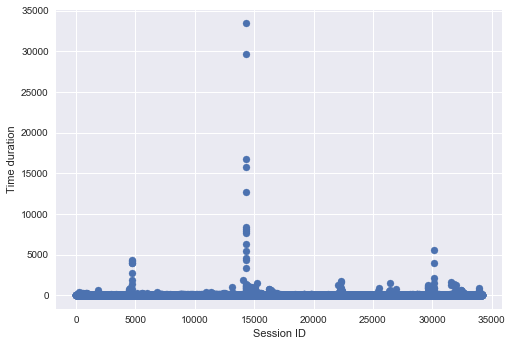

In [25]:
# Visualize the time duration of each session

# generate dataset
X = compressed_dataset['session.id']
y = compressed_dataset['session.duration']

# plot dataset
plt.scatter(X, y)

plt.xlabel("Session ID")
plt.ylabel("Time duration")
plt.show()

In [26]:
# Remove the outliers using Gaussian distribution
mean = np.mean(compressed_dataset['session.duration'], axis=0)
sd = np.std(compressed_dataset['session.duration'], axis=0)
compressed_dataset = compressed_dataset[compressed_dataset['session.duration'] > mean - 2 * sd]
compressed_dataset = compressed_dataset[compressed_dataset['session.duration'] < mean + 2 * sd]

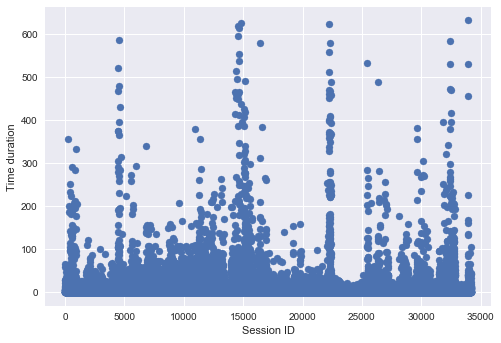

In [27]:
# Visualize the time duration of each session

# generate dataset
X = compressed_dataset['session.id']
y = compressed_dataset['session.duration']

# plot dataset
plt.scatter(X, y)

plt.xlabel("Session ID")
plt.ylabel("Time duration")
plt.show()

In [28]:
# Remove sessions that has zero time duration
compressed_dataset = compressed_dataset[compressed_dataset['session.duration'] != 0]
compressed_dataset = compressed_dataset.reset_index(drop=True)

In [29]:
output_filename = '../cleaned_data.csv'
compressed_dataset.to_csv(output_filename, header=True)

# 2. Data visualisation

In [30]:
input_filename = '../cleaned_data.csv'
clickdata_dataset = pd.read_csv(input_filename, encoding='utf-8', engine='python', index_col=0)

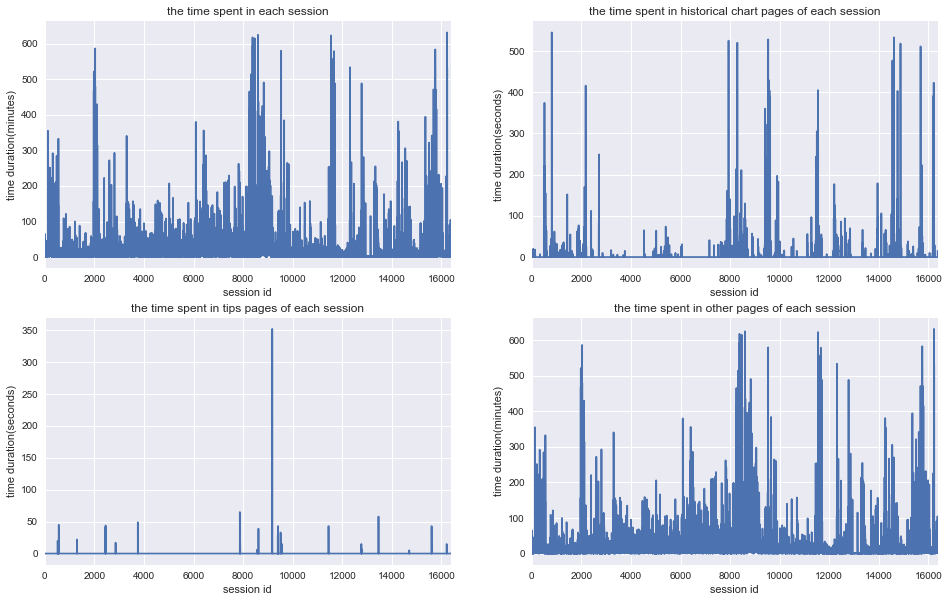

In [31]:
fig = plt.figure(figsize=(16, 10))

session = clickdata_dataset['session.duration']
hist = clickdata_dataset['hist.duration']
tips = clickdata_dataset['tips.duration']
others = clickdata_dataset['others.duration']

ax1 = fig.add_subplot(221)
ax1.set_xlabel('session id')
ax1.set_ylabel('time duration(minutes)')
ax1.set_title('the time spent in each session')
session.T.plot()

ax2 = fig.add_subplot(222)
ax2.set_xlabel('session id')
ax2.set_ylabel('time duration(seconds)')
ax2.set_title('the time spent in historical chart pages of each session')
hist.T.plot()

ax3 = fig.add_subplot(223)
ax3.set_xlabel('session id')
ax3.set_ylabel('time duration(seconds)')
ax3.set_title('the time spent in tips pages of each session')
tips.T.plot()

ax4 = fig.add_subplot(224)
ax4.set_xlabel('session id')
ax4.set_ylabel('time duration(minutes)')
ax4.set_title('the time spent in other pages of each session')
others.T.plot()

plt.show()

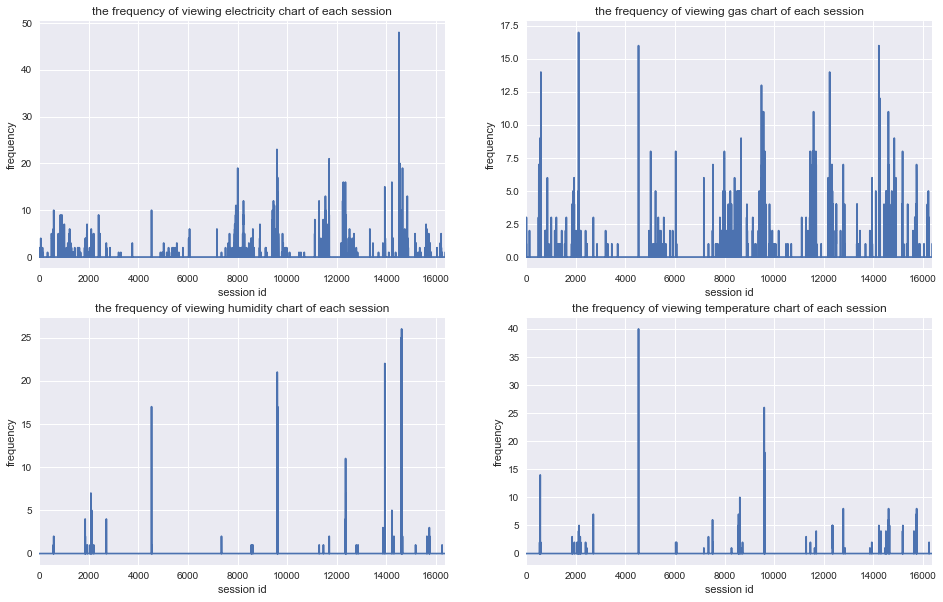

In [32]:
fig = plt.figure(figsize=(16, 10))

electricity = clickdata_dataset['hist.electricity']
gas = clickdata_dataset['hist.gas']
humidity = clickdata_dataset['hist.humidity']
temperature = clickdata_dataset['hist.temperature']

ax1 = fig.add_subplot(221)
ax1.set_xlabel('session id')
ax1.set_ylabel('frequency')
ax1.set_title('the frequency of viewing electricity chart of each session')
electricity.T.plot()

ax2 = fig.add_subplot(222)
ax2.set_xlabel('session id')
ax2.set_ylabel('frequency')
ax2.set_title('the frequency of viewing gas chart of each session')
gas.T.plot()

ax3 = fig.add_subplot(223)
ax3.set_xlabel('session id')
ax3.set_ylabel('frequency')
ax3.set_title('the frequency of viewing humidity chart of each session')
humidity.T.plot()

ax4 = fig.add_subplot(224)
ax4.set_xlabel('session id')
ax4.set_ylabel('frequency')
ax4.set_title('the frequency of viewing temperature chart of each session')
temperature.T.plot()

plt.show()

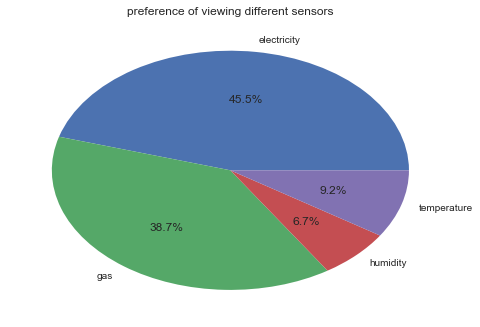

In [33]:
sensors = clickdata_dataset[['hist.electricity','hist.gas','hist.humidity','hist.temperature']]
sensors_sum = sensors.sum().to_frame()

plt.pie(sensors_sum,labels=['electricity','gas','humidity','temperature'],autopct='%1.1f%%')
plt.title('preference of viewing different sensors')
plt.show()

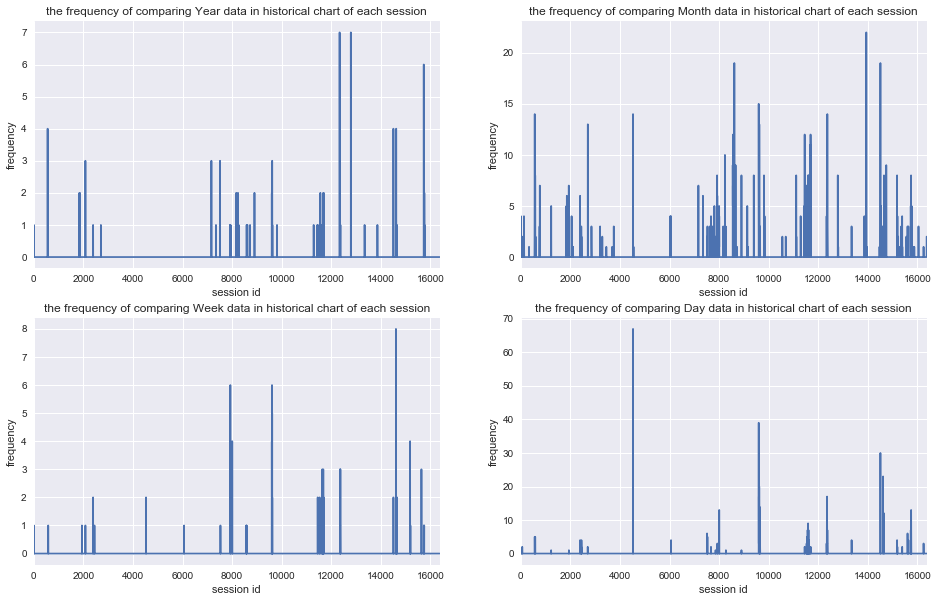

In [34]:
fig = plt.figure(figsize=(16, 10))

comparingYear = clickdata_dataset['hist.comparingYear']
comparingMonth = clickdata_dataset['hist.comparingMonth']
comparingWeek = clickdata_dataset['hist.comparingWeek']
comparingDay = clickdata_dataset['hist.comparingDay']

ax1 = fig.add_subplot(221)
ax1.set_xlabel('session id')
ax1.set_ylabel('frequency')
ax1.set_title('the frequency of comparing Year data in historical chart of each session')
comparingYear.T.plot()

ax2 = fig.add_subplot(222)
ax2.set_xlabel('session id')
ax2.set_ylabel('frequency')
ax2.set_title('the frequency of comparing Month data in historical chart of each session')
comparingMonth.T.plot()

ax3 = fig.add_subplot(223)
ax3.set_xlabel('session id')
ax3.set_ylabel('frequency')
ax3.set_title('the frequency of comparing Week data in historical chart of each session')
comparingWeek.T.plot()

ax4 = fig.add_subplot(224)
ax4.set_xlabel('session id')
ax4.set_ylabel('frequency')
ax4.set_title('the frequency of comparing Day data in historical chart of each session')
comparingDay.T.plot()

plt.show()

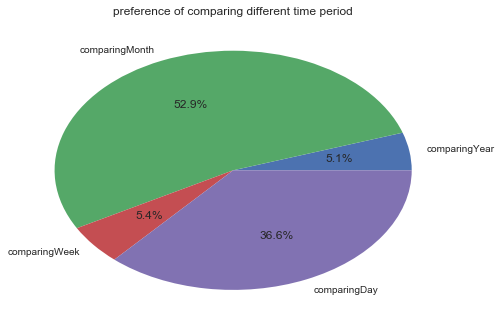

In [35]:
comparingYMWD = clickdata_dataset[['hist.comparingYear','hist.comparingMonth','hist.comparingWeek','hist.comparingDay']]
comparingYMWD_sum = comparingYMWD.sum().to_frame()

plt.pie(comparingYMWD_sum,labels=['comparingYear','comparingMonth','comparingWeek','comparingDay'],autopct='%1.1f%%')
plt.title('preference of comparing different time period')
plt.show()

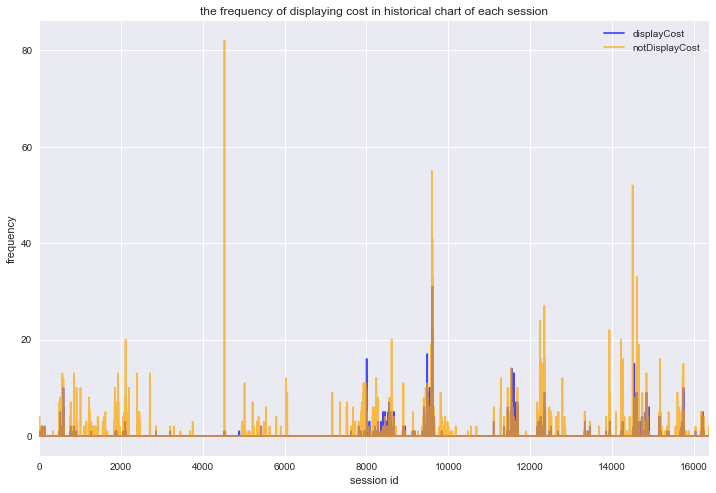

In [36]:
plt.figure(figsize=(12, 8))

hist_displayCost = clickdata_dataset['hist.displayCost']
hist_notDisplayCost = clickdata_dataset['hist.notDisplayCost']

hist_displayCost.T.plot(label='displayCost', alpha=0.7, color='blue')
hist_notDisplayCost.T.plot(label='notDisplayCost', alpha=0.7, color='orange')
plt.legend(loc='upper right')
plt.xlabel('session id')
plt.ylabel('frequency')
plt.title('the frequency of displaying cost in historical chart of each session')
plt.show()

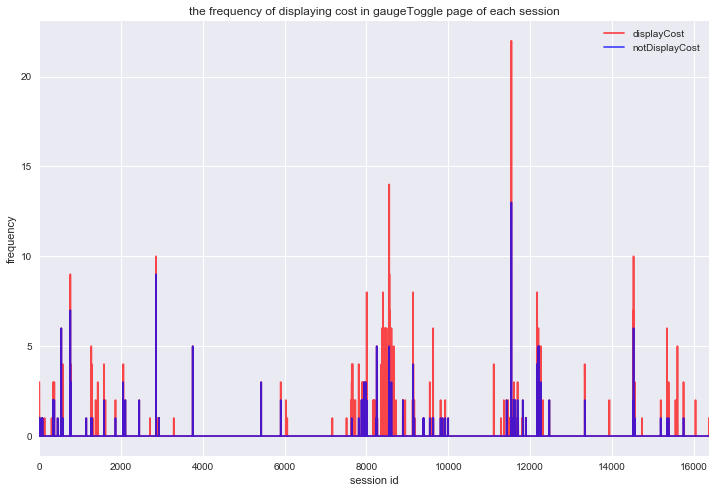

In [37]:
plt.figure(figsize=(12, 8))

hist_displayCost = clickdata_dataset['gaugeToggle.displayCost']
hist_notDisplayCost = clickdata_dataset['gaugeToggle.notDisplayCost']

hist_displayCost.T.plot(label='displayCost', alpha=0.7, color='red')
hist_notDisplayCost.T.plot(label='notDisplayCost', alpha=0.7, color='blue')
plt.legend(loc='upper right')
plt.xlabel('session id')
plt.ylabel('frequency')
plt.title('the frequency of displaying cost in gaugeToggle page of each session')
plt.show()

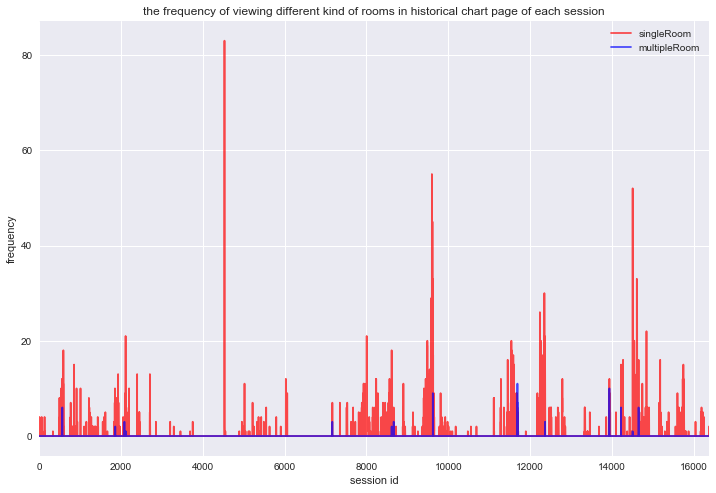

In [38]:
plt.figure(figsize=(12, 8))

hist_singleRoom = clickdata_dataset['hist.singleRoom']
hist_multipleRoom = clickdata_dataset['hist.multipleRoom']

hist_singleRoom.T.plot(label='singleRoom', alpha=0.7, color='red')
hist_multipleRoom.T.plot(label='multipleRoom', alpha=0.7, color='blue')
plt.legend(loc='upper right')
plt.xlabel('session id')
plt.ylabel('frequency')
plt.title('the frequency of viewing different kind of rooms in historical chart page of each session')
plt.show()

# 3. Clustering

In [39]:
columns = [
       'session.duration',
       'hist.electricity',
       'hist.gas',
       'hist.displayCost',
       'hist.notDisplayCost',
       'hist.duration',
       'tips.count',
       'tips.duration',
       'gaugeToggle.displayCost',
       'gaugeToggle.notDisplayCost',
       'welcome.duration',
       # NOT acceessible features for all users
       'hist.temperature',
       'hist.humidity',
       'hist.comparingYear',
       'hist.comparingMonth',
       'hist.comparingWeek',
       'hist.comparingDay',
       'hist.singleRoom',
       'hist.multipleRoom',
       'view.display',
       'others.duration',
        ]

input_filename = '../cleaned_data.csv'
clickdata_dataset = pd.read_csv(input_filename, encoding='utf-8', usecols=columns, engine='python')

## 3.1 Get the optimal number of clusters

### 3.1.1 The optimal number of clusters for k-means

In [40]:
# define the function to find the optimal clusters for k-means
def plot_optimal_KM_clusters(dataset, max_clusters):
    """Plot performance of different number of clusters.

    According to the plot, use 'elbow method' to find the optimal number of clusters.

    Args:
        dataset: The dataset is used for clustering.
        max_clusters: The max number of clusters used for searching.
    Returns:
        A plot shows the change of performance with the increse of cluster numbers.
    """
    # For each value of k calculate the sum of squared errors (SSE)
    K = range(1,max_clusters)
    KM = [KMeans(n_clusters=k, algorithm='full').fit(dataset) for k in K]
    centroids = [k.cluster_centers_ for k in KM]

    D_k = [cdist(dataset, cent, 'euclidean') for cent in centroids]
    cIdx = [np.argmin(D,axis=1) for D in D_k]
    dist = [np.min(D,axis=1) for D in D_k]
    avgWithinSS = [sum(d)/dataset.shape[0] for d in dist]

    # Total with-in sum of square
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(dataset)**2)/dataset.shape[0]
    bss = tss-wcss

    kIdx = 2 # point where rate of decline changes the most

    # plot elbow curve
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, avgWithinSS, 'b*-')
    ax.plot(K[kIdx], avgWithinSS[kIdx], marker='o', markersize=12, 
    markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.title('Elbow for KMeans clustering')
    plt.show()

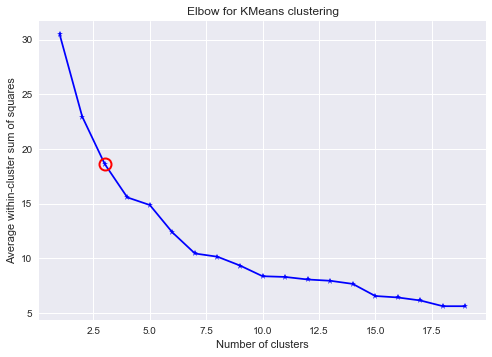

In [41]:
plot_optimal_KM_clusters(clickdata_dataset, 20)

### 3.1.2 The optimal number of clusters for Gaussian mixture model

In [42]:
# define the function to find the optimal clusters for Gaussian mixture model
def plot_optimal_GMM_clusters(dataset, max_clusters):
    """Plot performance of different number of clusters.

    According to the plot, use 'elbow method' to find the optimal number of clusters.

    Args:
        dataset: The dataset is used for clustering.
        max_clusters: The max number of clusters used for searching.
    Returns:
        A plot shows the change of performance with the increse of cluster numbers.
    """

    # find the optimal cluster number k using BIC
    bic = np.zeros(max_clusters-1)
    n = range(1,max_clusters)
    models = []
    #loop through each number of Gaussians and compute the BIC, and save the model
    for i,j in enumerate(n):
        #create mixture model with j components
        gmm = GaussianMixture(n_components=j)
        #fit it to the data
        gmm.fit(dataset)
        #compute the BIC for this model
        bic[i] = gmm.bic(dataset)
        #add the best-fit model with j components to the list of models
        models.append(gmm)

    plt.plot(n,bic,'-o',markevery=[1],color='b',markersize=12, 
             markeredgewidth=2, markeredgecolor='r', markerfacecolor='None') # Not sure 3
    plt.xlabel('Number of Gaussians')
    plt.ylabel('BIC ')
    plt.suptitle('Gaussian mixture model clustering ', fontweight='bold', fontsize=14)
    plt.show()

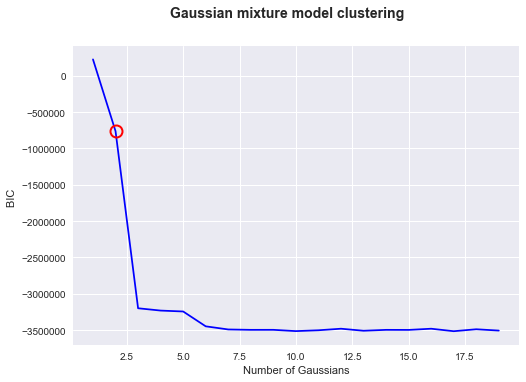

In [43]:
plot_optimal_GMM_clusters(clickdata_dataset, max_clusters=20)

### 3.1.3 The optimal number of clusters for hierarchical clustering

In [44]:
# define the function to find the optimal clusters for hierarchical clustering
def plot_optimal_HC_clusters(dataset):
    """Plot performance of different number of clusters.

    According to the plot, use 'elbow method' to find the optimal number of clusters.

    Args:
        dataset: The dataset is used for clustering.
        max_clusters: The max number of clusters used for searching.
    Returns:
        A plot shows the change of performance with the increse of cluster numbers.
    """
    
    # find the optimal cluster number k using 'ward method'
    data_dist = pdist(dataset,'euclidean') # computing the euclidean distance
    data_link = linkage(data_dist, method='ward') # computing the linkage

    dendrogram(data_link)
    plt.xlabel('Samples')
    plt.ylabel('Distance')
    plt.suptitle('Samples clustering', fontweight='bold', fontsize=14)
    plt.show()

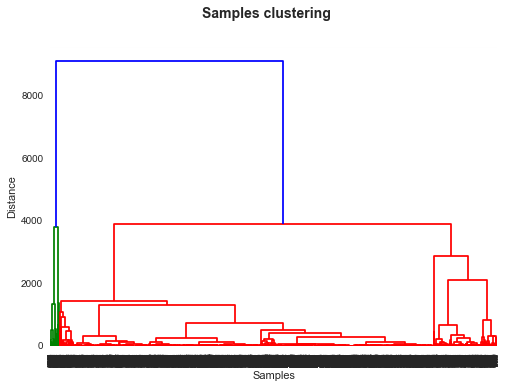

In [45]:
plot_optimal_HC_clusters(clickdata_dataset)

## 3.2 Get the optimal transformation methods

In [46]:
def plot_optimal_transformation_method(transformation_methods, dataset, clusters):
    """Plot performance of different transformation methods.

    According to the plot, find the optimal transformation methods.

    Args:
        dataset: The dataset is used for clustering.
        clusters: The number of clusters used for clustering.
        transformation_methods: This is a list of methods.
        clustering_method: This can be K-means, GMM....
    Returns:
        A plot shows the change of clustering performance(silhouette_score, calinski_harabaz_score)
        using different transformation methods.
    """
    silhouette_scores_KM = []
    calinski_harabaz_scores_KM = []
    silhouette_scores_GMM = []
    calinski_harabaz_scores_GMM = []
    silhouette_scores_HC = []
    calinski_harabaz_scores_HC = []
    
    for transformation_method in transformation_methods:
        if transformation_method == 'None':
            transformed_dataset = dataset
        else:
            transformed_dataset = transformation_method().fit(dataset).transform(dataset)
            
        # calculate metrics for different clustering algorithms
        # Hierarchical clustering
        data_dist = pdist(transformed_dataset,'euclidean') # computing the euclidean distance
        data_link = linkage(data_dist, method='ward') # computing the linkage
        labels_HC = fcluster(data_link, t=clusters, criterion='maxclust')
        silhouette_scores_HC.append(silhouette_score(transformed_dataset, labels_HC)) 
        calinski_harabaz_scores_HC.append(calinski_harabaz_score(transformed_dataset, labels_HC))
        
        # K-means clustering
        KM = KMeans(n_clusters=clusters).fit(transformed_dataset)
        labels_KM = KM.predict(transformed_dataset)
        silhouette_scores_KM.append(silhouette_score(transformed_dataset, labels_KM)) 
        calinski_harabaz_scores_KM.append(calinski_harabaz_score(transformed_dataset, labels_KM))
        
        # Gaussian mixture model
        GMM = GaussianMixture(n_components=clusters).fit(transformed_dataset)
        labels_GMM = GMM.predict(transformed_dataset)
        silhouette_scores_GMM.append(silhouette_score(transformed_dataset, labels_GMM)) 
        calinski_harabaz_scores_GMM.append(calinski_harabaz_score(transformed_dataset, labels_GMM))
    
    # plot the figure
    x_ticks_labels = ['None', 'MinMaxScaler', 'Normalizer', 'RobustScaler', 'StandardScaler']
    
    fig = plt.figure(figsize=(10,8))
    ax1 = fig.add_subplot(211)   
    ax1.plot(np.arange(len(silhouette_scores_KM)), silhouette_scores_KM, color="green", linestyle='--', marker='o')
    ax1.plot(np.arange(len(silhouette_scores_GMM)), silhouette_scores_GMM, color="blue", linestyle='--', marker='*')
    ax1.plot(np.arange(len(silhouette_scores_HC)), silhouette_scores_HC, color="red", linestyle='--', marker='+')
    ax1.set_xticks(np.arange(len(silhouette_scores_HC)))
    ax1.set_xticklabels(x_ticks_labels, rotation='horizontal', fontsize=10)
    ax1.set_title('The silhouette_scores using different transformation methods')
    ax1.set_xlabel("Transformation methods")
    ax1.set_ylabel("silhouette_score")
    ax1.legend(["K-means clustering","Gaussian mixture model","Hierarchical clustering"], loc="best")
    
    ax2 = fig.add_subplot(212)   
    ax2.plot(np.arange(len(calinski_harabaz_scores_KM)), calinski_harabaz_scores_KM, color="green", linestyle='--', marker='o')
    ax2.plot(np.arange(len(calinski_harabaz_scores_GMM)), calinski_harabaz_scores_GMM, color="blue", linestyle='--', marker='*')
    ax2.plot(np.arange(len(calinski_harabaz_scores_HC)), calinski_harabaz_scores_HC, color="red", linestyle='--', marker='+')
    ax2.set_xticks(np.arange(len(calinski_harabaz_scores_HC)))
    ax2.set_xticklabels(x_ticks_labels, rotation='horizontal', fontsize=10)
    ax2.set_title('The calinski_harabaz_scores using different transformation methods')
    ax2.set_xlabel("Transformation methods")
    ax2.set_ylabel("calinski_harabaz_score")
    ax2.legend(["K-means clustering","Gaussian mixture model","Hierarchical clustering"], loc="best")
    plt.tight_layout()
    plt.show()

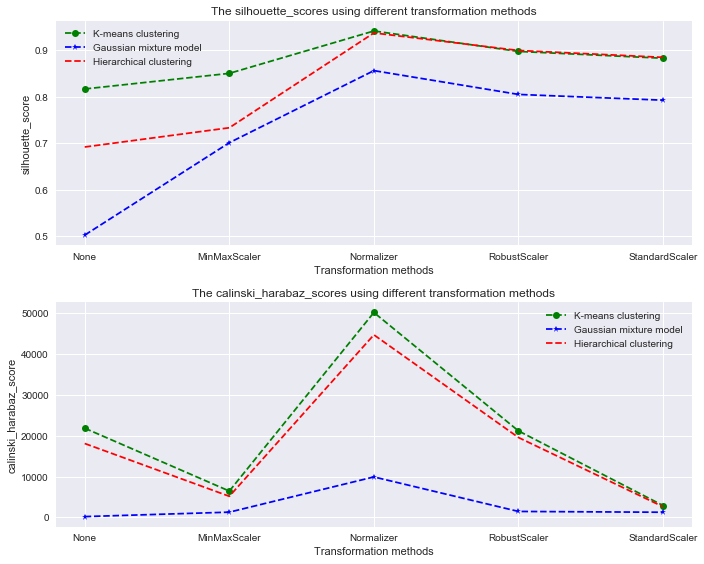

In [47]:
transformation_methods = ['None', MinMaxScaler, Normalizer, RobustScaler, StandardScaler]
plot_optimal_transformation_method(transformation_methods, clickdata_dataset, 3)

## 3.3 Get the optimal dimensions

In [48]:
def plot_optimal_feature_dimensions(clusters):
    """Plot performance of using different dimensions for clustering.

    According to the plot, find the optimal dimensions.

    Args:
        clusters: The optimal number of clusters.
    Returns:
        A plot shows the change of clustering performance(silhouette_score, calinski_harabaz_score)
        using different dimensions by different clustering methods.
    """
    input_filename = '../cleaned_data.csv'
    silhouette_scores_KM = []
    calinski_harabaz_scores_KM = []
    silhouette_scores_GMM = []
    calinski_harabaz_scores_GMM = []
    silhouette_scores_HC = []
    calinski_harabaz_scores_HC = []

    for i in range(2,22):   
        # read the dataset using i dimensions
        dataset = pd.read_csv(input_filename, encoding='utf-8', usecols=columns[:i], engine='python')
        transformed_dataset = Normalizer().fit(dataset).transform(dataset)
        
        
        # calculate metrics for different clustering algorithms
        # Hierarchical clustering
        data_dist = pdist(transformed_dataset,'euclidean') # computing the euclidean distance
        data_link = linkage(data_dist, method='ward') # computing the linkage
        labels_HC = fcluster(data_link, t=15, criterion='distance')
        silhouette_scores_HC.append(silhouette_score(transformed_dataset, labels_HC)) 
        calinski_harabaz_scores_HC.append(calinski_harabaz_score(transformed_dataset, labels_HC))
        
        # K-means clustering
        KM = KMeans(n_clusters=clusters).fit(transformed_dataset)
        labels_KM = KM.predict(transformed_dataset)
        silhouette_scores_KM.append(silhouette_score(transformed_dataset, labels_KM)) 
        calinski_harabaz_scores_KM.append(calinski_harabaz_score(transformed_dataset, labels_KM))
        
        # Gaussian mixture model
        GMM = GaussianMixture(n_components=clusters).fit(transformed_dataset)
        labels_GMM = GMM.predict(transformed_dataset)
        silhouette_scores_GMM.append(silhouette_score(transformed_dataset, labels_GMM)) 
        calinski_harabaz_scores_GMM.append(calinski_harabaz_score(transformed_dataset, labels_GMM))

    # plot the figure
    fig = plt.figure(figsize=(10,8))
    ax1 = fig.add_subplot(211)   
    ax1.plot(np.arange(2,22), silhouette_scores_HC, color="green", linestyle='--', marker='o')
    ax1.plot(np.arange(2,22), silhouette_scores_KM, color="blue", linestyle='--', marker='o')
    ax1.plot(np.arange(2,22), silhouette_scores_GMM, color="red", linestyle='--', marker='o')
    ax1.set_title('The silhouette_scores using different dimensions by different clustering algorithms')
    ax1.set_xlabel("The number of dimensions")
    ax1.set_ylabel("silhouette_score")
    ax1.legend(["Hierarchical clustering", "K-means clustering", "Gaussian mixture model"], loc="best")

    ax2 = fig.add_subplot(212)   
    ax2.plot(np.arange(2,22), calinski_harabaz_scores_HC, color="green", linestyle='--', marker='o')
    ax2.plot(np.arange(2,22), calinski_harabaz_scores_KM, color="blue", linestyle='--', marker='o')
    ax2.plot(np.arange(2,22), calinski_harabaz_scores_GMM, color="red", linestyle='--', marker='o')
    ax2.set_title('The calinski_harabaz_scores using different dimensions by different clustering algorithms')
    ax2.set_xlabel("The number of dimensions")
    ax2.set_ylabel("calinski_harabaz_score")
    ax2.legend(["Hierarchical clustering", "K-means clustering", "Gaussian mixture model"], loc="best")
    
    plt.tight_layout()
    plt.show()

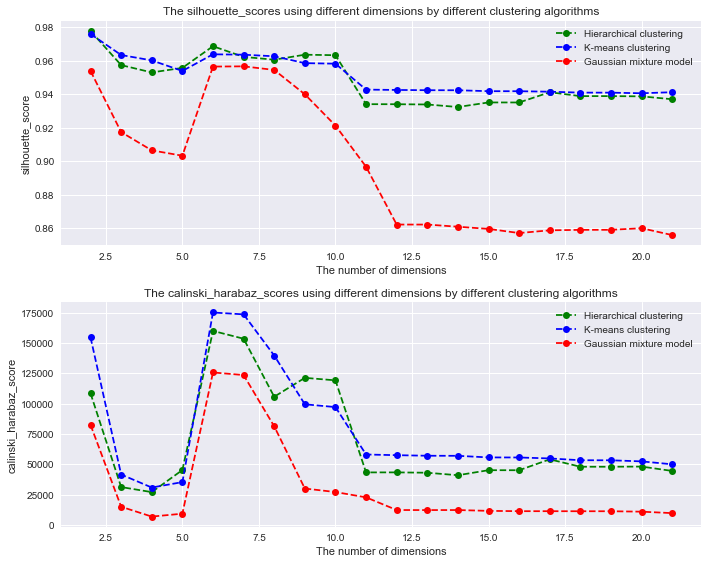

In [49]:
plot_optimal_feature_dimensions(clusters=3)

## 3.4 Compare different methods using different dimensions

In [50]:
def calculate_evolution(clusters):
    """Calculate the labels that different clustering algorithms run on the different dimensions.

    Simply choose 3 dimensions, that are 1 dimension, 12 dimensions and all the dimensions(21).
    The first 1 dimension is the session.duration, I just want to use this as a baseline.
    The first 12 dimensions are the dimensions that are available for all users.
    The whole dimensions are the dimensions we can use in the dataset.

    Args:
        clusters: The optimal number of clusters.
    Returns:
        Three lists of labels, which records the clustering results.
    """
    input_filename = '../cleaned_data.csv'
    dimensions = [1,11,12,21]
    labels_HC = []
    labels_KM = []
    labels_GMM = []
    
    for i in dimensions:   
        # read the dataset using i dimensions
        if i == 11:
            dataset = pd.read_csv(input_filename, encoding='utf-8', usecols=columns[1:i], engine='python')
        else:
            dataset = pd.read_csv(input_filename, encoding='utf-8', usecols=columns[:i], engine='python')
        
        if i == 1:
            transformed_dataset = dataset
        else:
            transformed_dataset = Normalizer().fit(dataset).transform(dataset)
    
        # calculate metrics for different clustering algorithms
        # Hierarchical clustering
        data_dist = pdist(transformed_dataset,'euclidean') # computing the euclidean distance
        data_link = linkage(data_dist, method='ward') # computing the linkage
        label_HC = fcluster(data_link, t=clusters, criterion='maxclust')
        labels_HC.append(label_HC)
        
        # K-means clustering
        KM = KMeans(n_clusters=clusters).fit(transformed_dataset)
        label_KM = KM.predict(transformed_dataset)
        labels_KM.append(label_KM)
        
        # Gaussian mixture model
        GMM = GaussianMixture(n_components=clusters).fit(transformed_dataset)
        label_GMM = GMM.predict(transformed_dataset)
        labels_GMM.append(label_GMM)
    
    return (labels_HC, labels_KM, labels_GMM)

def plot_evolution(labels_HC, labels_KM, labels_GMM):
    """Visualize the evolution of clusters changed with the increase of dimensions.

    Simply choose 3 dimensions, that are 1 dimension, 11 dimensions, 12 dimensions and all the dimensions(21).
    The first 1 dimension is the session.duration, I just want to use this as a baseline.
    The 11 dimensions are the dimensions that all available for all users except for session.duration.
    The first 12 dimensions are the dimensions that are available for all users.
    The whole dimensions are the dimensions we can use in the dataset.

    Args:
        labels_HC: The labels got from Hierarchical clustering
        labels_KM: The labels got from K-means clustering
        labels_GMM: The labels got from Gaussian mixture model
    Returns:
        A plot shows evolution of clusters changed, based on this, we can know what is the difference using different
        algorithms and different dimensions.
    """
    input_filename = '../cleaned_data.csv'
    dimensions = [1,1,1,11,11,11,12,12,12,21,21,21]
    
    clickdata_dataset = pd.read_csv(input_filename, encoding='utf-8', engine='python')

    fig, axes = plt.subplots(4, 3, figsize=(20, 10))
    ax = axes.ravel()

    for i,j in zip(range(12), dimensions):
        if i == 0 or i == 3 or i == 6 or i == 9:
            label = pd.DataFrame(data=labels_HC[int(i/3)],columns=['label'])
            labeled_clickdata_dataset = pd.concat([clickdata_dataset, label],axis=1)
            cluster_0 = labeled_clickdata_dataset[labeled_clickdata_dataset['label'] == 1]
            cluster_1 = labeled_clickdata_dataset[labeled_clickdata_dataset['label'] == 2]
            cluster_2 = labeled_clickdata_dataset[labeled_clickdata_dataset['label'] == 3]
            c0 = ax[i].scatter(cluster_0['session.id'],cluster_0['session.duration'],c='r',marker='+')
            c1 = ax[i].scatter(cluster_1['session.id'],cluster_1['session.duration'],c='g',marker='o')
            c2 = ax[i].scatter(cluster_2['session.id'],cluster_2['session.duration'],c='b',marker='*')
            ax[i].legend([c0, c1, c2], ['cluster1', 'cluster2','cluster3'])
            ax[i].set_title('Hierarchical clustering using %d dimensions' % j)
            ax[i].set_xlabel("Session ID")
            ax[i].set_ylabel("Session duration")
        elif i == 1 or i == 4 or i == 7 or i == 10:
            label = pd.DataFrame(data=labels_KM[int((i-1)/3)],columns=['label'])
            labeled_clickdata_dataset = pd.concat([clickdata_dataset, label],axis=1)
            cluster_0 = labeled_clickdata_dataset[labeled_clickdata_dataset['label'] == 0]
            cluster_1 = labeled_clickdata_dataset[labeled_clickdata_dataset['label'] == 1]
            cluster_2 = labeled_clickdata_dataset[labeled_clickdata_dataset['label'] == 2]
            c0 = ax[i].scatter(cluster_0['session.id'],cluster_0['session.duration'],c='r',marker='+')
            c1 = ax[i].scatter(cluster_1['session.id'],cluster_1['session.duration'],c='g',marker='o')
            c2 = ax[i].scatter(cluster_2['session.id'],cluster_2['session.duration'],c='b',marker='*')
            ax[i].legend([c0, c1, c2], ['cluster1', 'cluster2','cluster3'])
            ax[i].set_title('K-means clustering using %d dimensions' % j)
            ax[i].set_xlabel("Session ID")
            ax[i].set_ylabel("Session duration")
        else:
            label = pd.DataFrame(data=labels_GMM[int((i-2)/3)],columns=['label'])
            labeled_clickdata_dataset = pd.concat([clickdata_dataset, label],axis=1)
            cluster_0 = labeled_clickdata_dataset[labeled_clickdata_dataset['label'] == 0]
            cluster_1 = labeled_clickdata_dataset[labeled_clickdata_dataset['label'] == 1]
            cluster_2 = labeled_clickdata_dataset[labeled_clickdata_dataset['label'] == 2]
            c0 = ax[i].scatter(cluster_0['session.id'],cluster_0['session.duration'],c='r',marker='+')
            c1 = ax[i].scatter(cluster_1['session.id'],cluster_1['session.duration'],c='g',marker='o')
            c2 = ax[i].scatter(cluster_2['session.id'],cluster_2['session.duration'],c='b',marker='*')
            ax[i].legend([c0, c1, c2], ['cluster1', 'cluster2','cluster3'])
            ax[i].set_title('Gaussian mixture model clustering using %d dimensions' % j)
            ax[i].set_xlabel("Session ID")
            ax[i].set_ylabel("Session duration")
    fig.tight_layout()        
    plt.show()
    

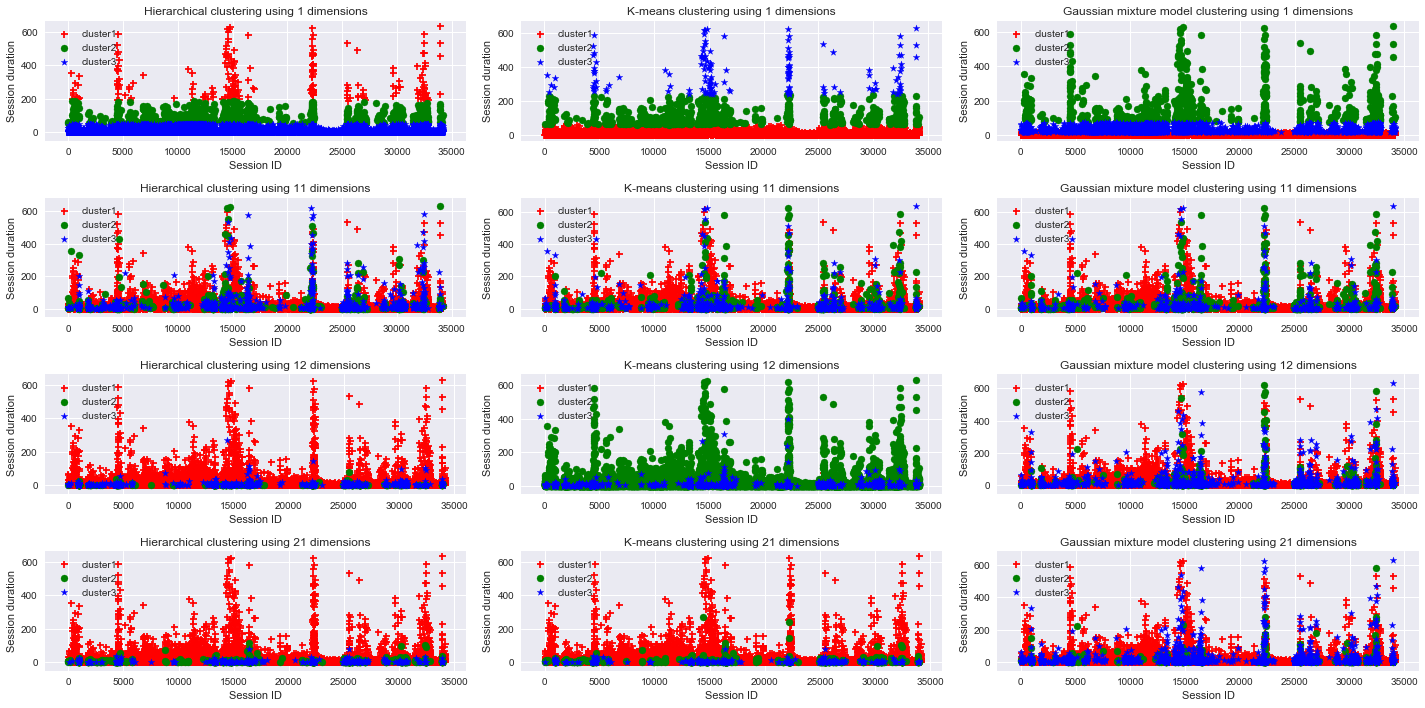

In [51]:
labels_HC, labels_KM, labels_GMM = calculate_evolution(3)
plot_evolution(labels_HC, labels_KM, labels_GMM)

## 3.5 Visualize the influence of each dimension for each clustering results

In [52]:
def calculate_clustering_evolution(clusters, clustering):
    """Calculate the labels that different clustering algorithms run on the different dimensions.

    Simply choose 3 dimensions, that are 1 dimension, 12 dimensions and all the dimensions(21).
    The first 1 dimension is the session.duration, I just want to use this as a baseline.
    The first 12 dimensions are the dimensions that are available for all users.
    The whole dimensions are the dimensions we can use in the dataset.

    Args:
        clusters: The optimal number of clusters.
    Returns:
        Three lists of labels, which records the clustering results.
    """
    input_filename = '../cleaned_data.csv'
    labels = []
    
    for i in range(1,13):   
        # read the dataset using i dimensions
        dataset = pd.read_csv(input_filename, encoding='utf-8', usecols=columns[:i], engine='python')
        
        if i == 1:
            transformed_dataset = dataset
        else:
            transformed_dataset = Normalizer().fit(dataset).transform(dataset)
          
        # calculate metrics for different clustering algorithms
        # Hierarchical clustering
        if clustering == 'HC':
            data_dist = pdist(transformed_dataset,'euclidean') # computing the euclidean distance
            data_link = linkage(data_dist, method='ward') # computing the linkage
            label_HC = fcluster(data_link, t=clusters, criterion='maxclust')
            labels.append(label_HC)
        elif clustering == 'KM':
            # K-means clustering
            KM = KMeans(n_clusters=clusters).fit(transformed_dataset)
            label_KM = KM.predict(transformed_dataset)
            labels.append(label_KM)
        elif clustering == 'GMM':
            # Gaussian mixture model
            GMM = GaussianMixture(n_components=clusters).fit(transformed_dataset)
            label_GMM = GMM.predict(transformed_dataset)
            labels.append(label_GMM)

    return labels

def plot_clustering_evolution(labels, clustering):
    """Visualize the evolution of clusters changed with the increase of dimensions.

    Simply choose 3 dimensions, that are 1 dimension, 12 dimensions and all the dimensions(21).
    The first 1 dimension is the session.duration, I just want to use this as a baseline.
    The first 12 dimensions are the dimensions that are available for all users.
    The whole dimensions are the dimensions we can use in the dataset.

    Args:
        labels_HC: The labels got from Hierarchical clustering
        labels_KM: The labels got from K-means clustering
        labels_GMM: The labels got from Gaussian mixture model
    Returns:
        A plot shows evolution of clusters changed, based on this, we can know what is the difference using different
        algorithms and different dimensions.
    """
    input_filename = '../cleaned_data.csv'
    
    clickdata_dataset = pd.read_csv(input_filename, encoding='utf-8', engine='python')

    fig, axes = plt.subplots(4, 3, figsize=(20, 10))
    ax = axes.ravel()

    for i in range(12):
        label = pd.DataFrame(data=labels[i],columns=['label'])
        labeled_clickdata_dataset = pd.concat([clickdata_dataset, label],axis=1)
        if clustering == 'HC':
            cluster_0 = labeled_clickdata_dataset[labeled_clickdata_dataset['label'] == 1]
            cluster_1 = labeled_clickdata_dataset[labeled_clickdata_dataset['label'] == 2]
            cluster_2 = labeled_clickdata_dataset[labeled_clickdata_dataset['label'] == 3]
        else:
            cluster_0 = labeled_clickdata_dataset[labeled_clickdata_dataset['label'] == 0]
            cluster_1 = labeled_clickdata_dataset[labeled_clickdata_dataset['label'] == 1]
            cluster_2 = labeled_clickdata_dataset[labeled_clickdata_dataset['label'] == 2]    
                   
        c0 = ax[i].scatter(cluster_0['session.id'],cluster_0['session.duration'],c='r',marker='+')
        c1 = ax[i].scatter(cluster_1['session.id'],cluster_1['session.duration'],c='g',marker='o')
        c2 = ax[i].scatter(cluster_2['session.id'],cluster_2['session.duration'],c='b',marker='*')
        ax[i].legend([c0, c1, c2], ['cluster1', 'cluster2','cluster3'])
                   
        if clustering == 'HC':
            ax[i].set_title('Hierarchical clustering using %d dimensions' % (i+1))
        elif clustering == 'KM':
            ax[i].set_title('K-means clustering using %d dimensions' % (i+1) )      
        elif clustering == 'GMM':
            ax[i].set_title('Gaussian mixture model clustering using %d dimensions' % (i+1))      
                   
        ax[i].set_xlabel("Session ID")
        ax[i].set_ylabel("Session duration")
        
    fig.tight_layout()        
    plt.show()
    

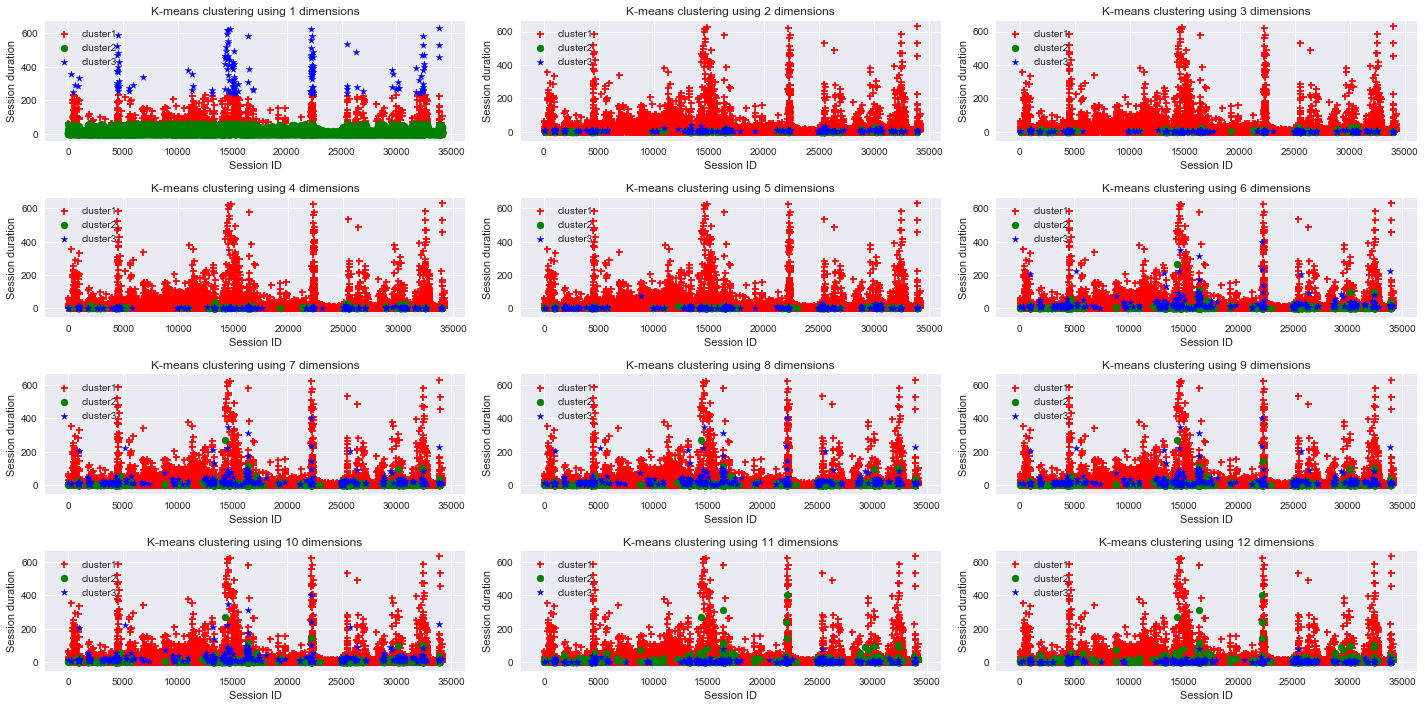

In [53]:
labels = calculate_clustering_evolution(3, 'KM')
plot_clustering_evolution(labels, 'KM')

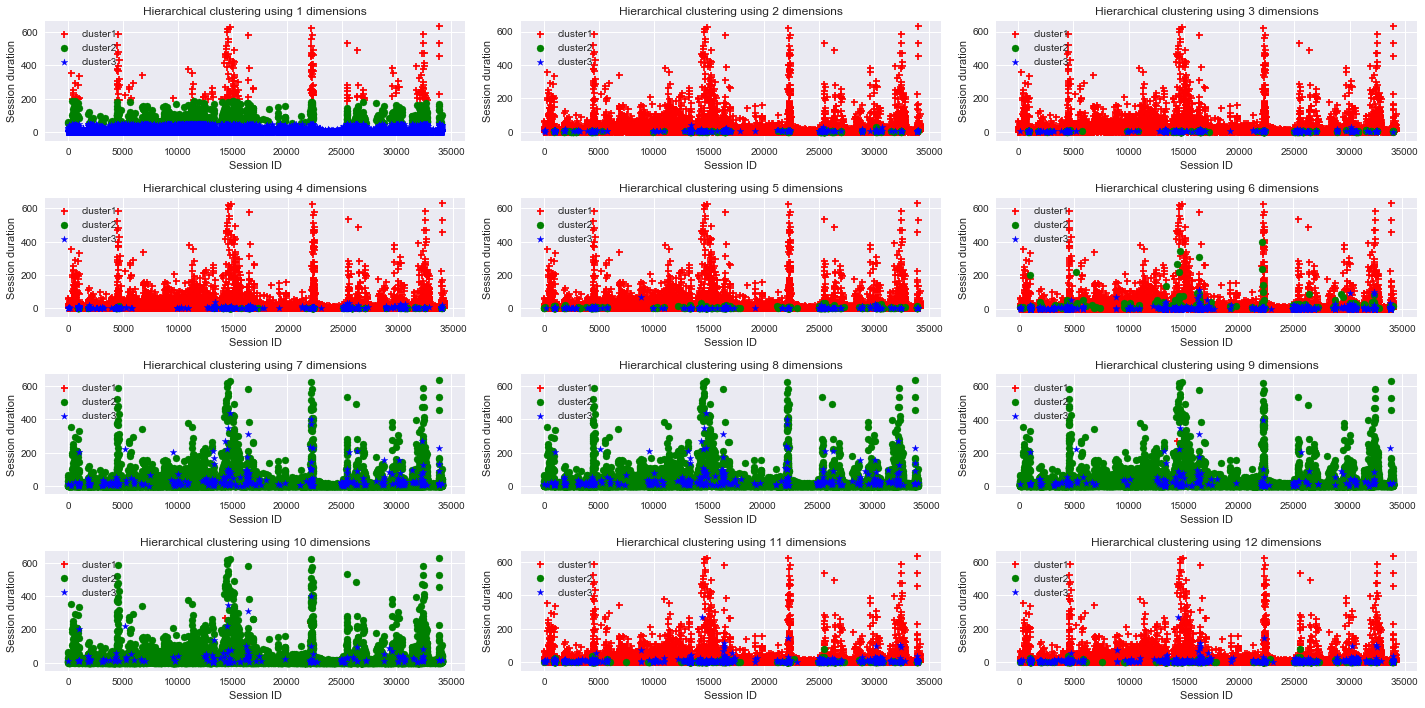

In [54]:
labels = calculate_clustering_evolution(3, 'HC')
plot_clustering_evolution(labels, 'HC')

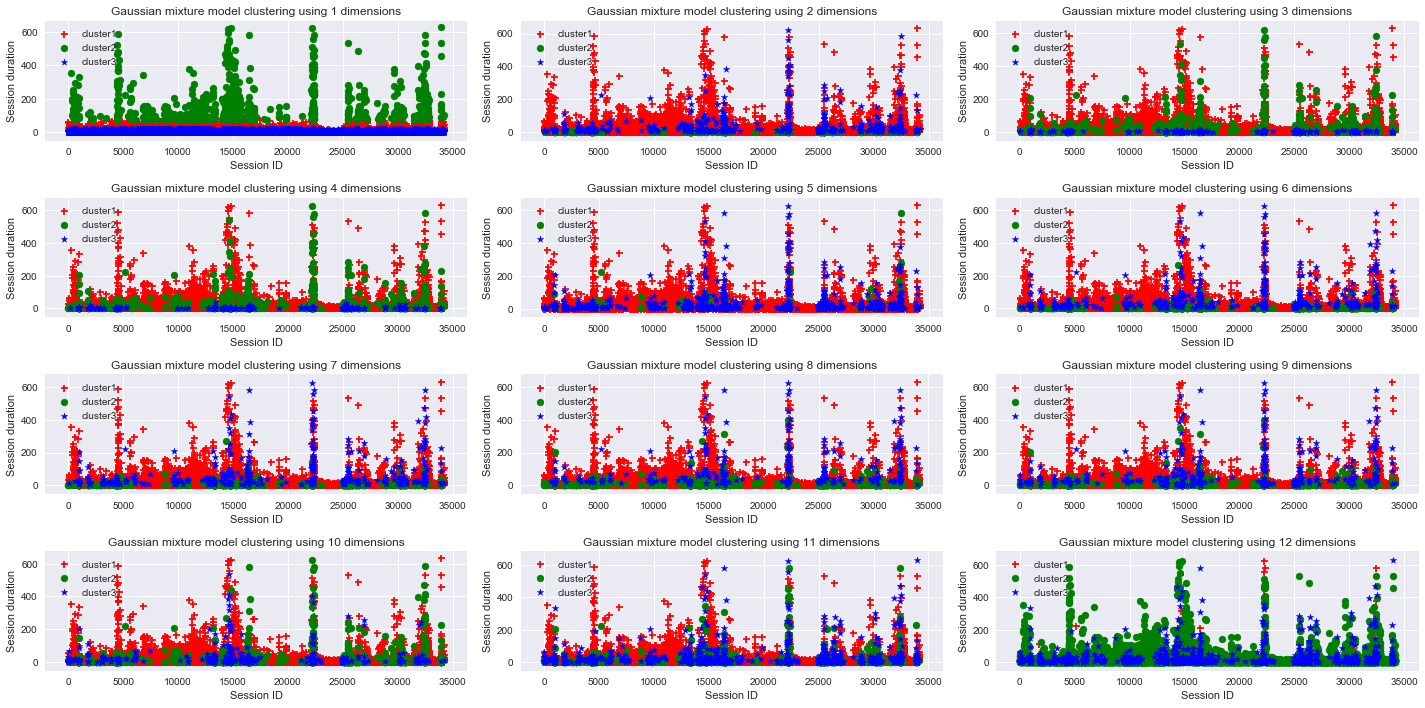

In [55]:
labels = calculate_clustering_evolution(3, 'GMM')
plot_clustering_evolution(labels, 'GMM')

# 4. Usage pattern change

In [66]:
columns = [
       'session.duration',
       'hist.electricity',
       'hist.gas',
       'hist.displayCost',
       'hist.notDisplayCost',
       'hist.duration',
       'tips.count',
       'tips.duration',
       'gaugeToggle.displayCost',
       'gaugeToggle.notDisplayCost',
       'welcome.duration',
       # NOT acceessible features for all users
       'hist.temperature',
       'hist.humidity',
       'hist.comparingYear',
       'hist.comparingMonth',
       'hist.comparingWeek',
       'hist.comparingDay',
       'hist.singleRoom',
       'hist.multipleRoom',
       'view.display',
       'others.duration',
        ]

input_filename = '../cleaned_data.csv'
users_filename = '../appuser.csv'
releaseDate_filename = '../release_data.csv'

dataset = pd.read_csv(input_filename, encoding='utf-8', engine='python', index_col=0)
user_dataset = pd.read_csv(users_filename, encoding='utf-8', engine='python', index_col=0)
clickdata_dataset = pd.read_csv(input_filename, encoding='utf-8', usecols=columns, engine='python')
releaseDate_dataset = pd.read_csv(releaseDate_filename, encoding='utf-8', engine='python')

transformed_dataset = Normalizer().fit(clickdata_dataset).transform(clickdata_dataset)

In [67]:
clusters = 3
# Hierarchical clustering
data_dist = pdist(transformed_dataset,'euclidean') # computing the euclidean distance
data_link = linkage(data_dist, method='ward') # computing the linkage
labels_HC = fcluster(data_link, t=clusters, criterion='maxclust')

# K-means clustering
KM = KMeans(n_clusters=clusters).fit(transformed_dataset)
labels_KM = KM.predict(transformed_dataset)

# Gaussian mixture model
GMM = GaussianMixture(n_components=clusters).fit(transformed_dataset)
labels_GMM = GMM.predict(transformed_dataset)

In [68]:
labels_HC = pd.DataFrame(data=labels_HC, columns=['label'])
dataset_HC = pd.concat([dataset, labels_HC], axis=1)
dataset_HC['state'] = np.nan

labels_KM = pd.DataFrame(data=labels_HC, columns=['label'])
dataset_KM = pd.concat([dataset, labels_KM], axis=1)
dataset_KM['state'] = np.nan

labels_GMM = pd.DataFrame(data=labels_HC, columns=['label'])
dataset_GMM = pd.concat([dataset, labels_GMM], axis=1)
dataset_GMM['state'] = np.nan

## 4.1 Separate the session into three groups

In [ ]:
users = user_dataset['appuserid']
count = 0
stable_users = []
less_stable_users = []
unstable_users = []

for user in users:
    user_sessions_HC = dataset_HC[dataset_HC['guiAccess.userid'] == user]
    user_sessions_KM = dataset_KM[dataset_KM['guiAccess.userid'] == user]
    user_sessions_GMM = dataset_GMM[dataset_GMM['guiAccess.userid'] == user]
    
    if len(user_sessions_HC['label'].unique()) == 1:
        dataset_HC.ix[dataset_HC['guiAccess.userid'] == user, 'state'] = 'stable'
    elif len(user_sessions_HC['label'].unique()) == 2:
        dataset_HC.ix[dataset_HC['guiAccess.userid'] == user, 'state'] = 'less_stable'
    else:
        dataset_HC.ix[dataset_HC['guiAccess.userid'] == user, 'state'] = 'unstable'
    
    if len(user_sessions_KM['label'].unique()) == 1:
        dataset_KM.ix[dataset_HC['guiAccess.userid'] == user, 'state'] = 'stable'
    elif len(user_sessions_KM['label'].unique()) == 2:
        dataset_KM.ix[dataset_HC['guiAccess.userid'] == user, 'state'] = 'less_stable'
    else:
        dataset_KM.ix[dataset_HC['guiAccess.userid'] == user, 'state'] = 'unstable'
    
    if len(user_sessions_GMM['label'].unique()) == 1:
        dataset_GMM.ix[dataset_HC['guiAccess.userid'] == user, 'state'] = 'stable'
    elif len(user_sessions_GMM['label'].unique()) == 2:
        dataset_GMM.ix[dataset_HC['guiAccess.userid'] == user, 'state'] = 'less_stable'
    else:
        dataset_GMM.ix[dataset_HC['guiAccess.userid'] == user, 'state'] = 'unstable'

In [93]:
releaseDate_dataset = releaseDate_dataset.fillna('empty')

In [96]:
def plot_user_pattern(labeled_dataset, user_dataset):
    
    user_num = len(labeled_dataset['guiAccess.userid'].unique())
    user_dataset = labeled_dataset['guiAccess.userid'].unique()
    row = 0
    if user_num % 2 == 0:
        row = user_num // 2
    else:
        row = user_num // 2 + 1
    
    fig, axes = plt.subplots(row, 2, figsize=(10, 60))
    ax = axes.ravel()
    colors = ['red','green','orange']
    count = 0
    
    for user in user_dataset:
        user_session = labeled_dataset[labeled_dataset['guiAccess.userid'] == user]
        user_session.loc[:,'guiAccess.timestamp.start'] = pd.to_datetime(user_session.loc[:,'guiAccess.timestamp.start'], errors='coerce')
        X = user_session['guiAccess.timestamp.start']
        y = user_session['label']
        
        releaseDate = releaseDate_dataset[releaseDate_dataset['appuserid'] == user]
        enhance_view = releaseDate['ENHANCED_VIEW']
        compare_chart = releaseDate['COMPARE_CHART']
        dual_chart = releaseDate['DUAL_CHART']
        
        if enhance_view.empty == False:
             if enhance_view.iloc[0] != 'empty':
                ax[count].axvline(x=pd.to_datetime(enhance_view.iloc[0]), color='blue')
        
        if compare_chart.empty == False:
            if compare_chart.iloc[0] != 'empty':
                ax[count].axvline(x=pd.to_datetime(compare_chart.iloc[0]), color='black')
        
        if dual_chart.empty == False:
            if dual_chart.iloc[0] != 'empty':
                ax[count].axvline(x=pd.to_datetime(dual_chart.iloc[0]), color='yellow')
        
        # every five user shown in the same graph
        if user_session['state'].unique() == 'stable':
            ax[count].plot(X, y, color='red', linestyle='--', marker='o')
        elif user_session['state'].unique() == 'less_stable':
            ax[count].plot(X, y, color='green', linestyle='--', marker='o')
        else:
            ax[count].plot(X, y, color='orange', linestyle='--', marker='o')
        ax[count].set_xlabel("Date")
        ax[count].set_ylabel("Cluster")
        ax[count].set_title('%s usage pattern change over time' % user)
        count += 1

    fig.tight_layout()

/Users/mao/anaconda/envs/project/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



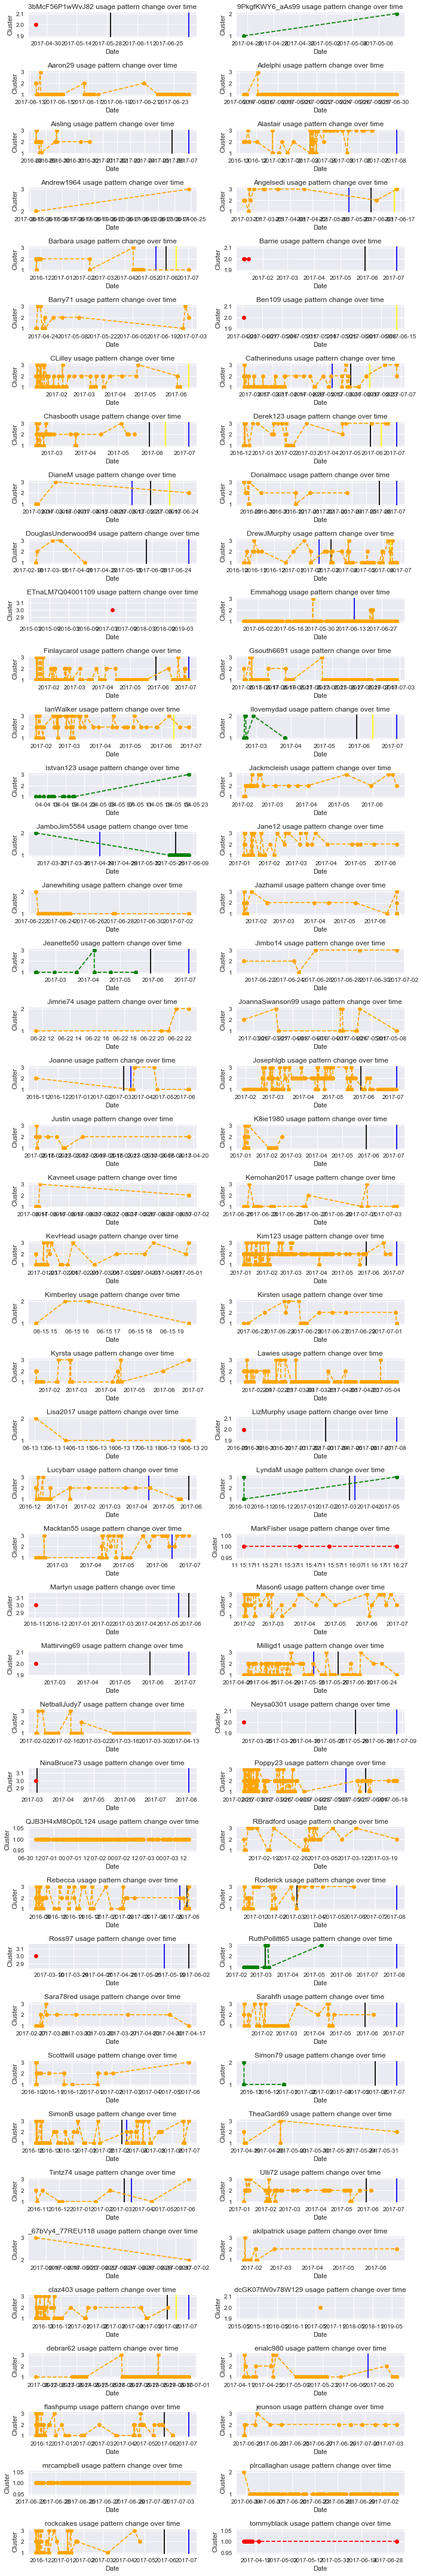

In [97]:
plot_user_pattern(dataset_GMM, user_dataset)